# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [1]:
import os
import csv
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import inspect
from tqdm import tqdm
from multiprocessing import Pool

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [2]:
# set up test parameters
dataset_dir = os.path.join('A37_example_test') # dataset directory
schema_path = os.path.join('data', dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

In [3]:
# Set up base parameters of system.
ids = [5,11,14,16,24,29]

In [4]:
# Set up probabilistic model of effiencies and take draws
n_draws = 100
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_draws,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

In [5]:
#num_scenarios = [1,2,3,5,8,10,15,20,25]
num_scenarios = [1,2]
num_buildings = [1,2,3]

buildings_results = {}

for B in num_buildings:
    runtimes = {}
    for M in num_scenarios:
        if B*M <= 30:
            print(f"# Scenarios: {M}")

            base_kwargs = {
                'output_dir_path': os.path.join('data','A37_example_test'),
                'building_names': ['UCam_Building_%s'%id for id in ids][:B],
                'battery_energy_capacities': [3127.0,2736.0,2746.0,2448.0,4788.0,4565.0][:B], # from Annex 37
                'battery_power_capacities': [391.0,342.0,343.0,306.0,598.0,571.0][:B], # from Annex 37
                'battery_efficiencies': None,
                'pv_power_capacities': [178.0,41.0,57.0,120.0,1349.0,257.0][:B], # from Annex 37
                'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids][:B],
                'weather_data_path': 'weather.csv',
                'carbon_intensity_data_path': 'carbon_intensity.csv',
                'pricing_data_path': 'pricing.csv',
                'schema_name': 'schema_temp'
            }

            envs = []

            etas = [eta_samples[k] for k in range(M)] # get M samples

            for m in range(M):
                # Build schema.
                base_kwargs.update({
                        'battery_efficiencies': etas[m][:B]
                    })
                schema_path = build_schema(**base_kwargs)

                # Initialise CityLearn environment object.
                envs.append(CityLearnEnv(schema=schema_path))

                if m == 0: # initialise lp object
                    lp = LinProgModel(env=envs[m])
                else:
                    lp.add_env(env=envs[m])

            lp.set_time_data_from_envs()
            lp.generate_LP(clip_level='m',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
            lp.set_LP_parameters()

            start = time.time()
            lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
            end = time.time()

            print(lp_results['battery_capacities'],lp_results['solar_capacities'])

            runtimes.update({M: end-start})
            print(f"Solve time: {round(runtimes[M],1)}s")

    buildings_results[B] = runtimes

# Scenarios: 1
[1104.34841772] [782.59717503]
Solve time: 9.4s
# Scenarios: 2
[1099.0141388] [790.78421311]
Solve time: 43.3s
# Scenarios: 1
[1102.59844793  928.47666816] [779.3160335  661.81757732]
Solve time: 49.6s
# Scenarios: 2
[1087.72459742  928.68318768] [787.37579888 649.01273277]
Solve time: 188.8s
# Scenarios: 1
[1098.46254943  926.63458704  829.47334778] [777.77176258 661.00937656 641.38770178]
Solve time: 176.9s
# Scenarios: 2
[1084.69500849  927.56931472  825.71933546] [786.43410853 647.70992366 653.96825397]
Solve time: 686.7s


In [6]:
# Fit linear trend to log(runtime)
trends = {B: np.polyfit(np.log(list(buildings_results[B].keys())),np.log(list(buildings_results[B].values())),deg=1) for B in num_buildings}
print(trends)

{1: array([2.19860919, 2.24460754]), 2: array([1.93012184, 3.90304801]), 3: array([1.9566281 , 5.17567689])}


In [7]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trends[1][1])/trends[1][0])
print(scenarios_limit)

131.77206154938335


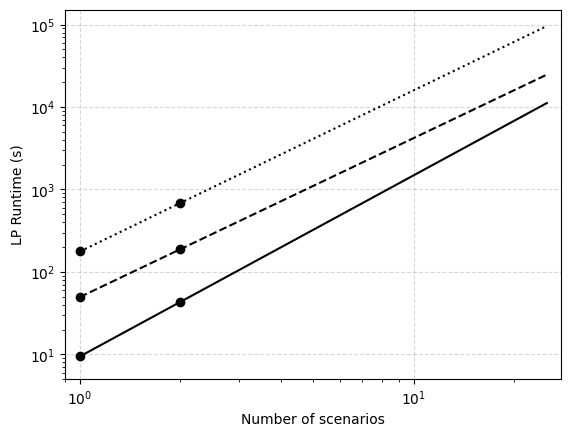

In [8]:
# Plot computational time results
lss = ['-','--',':']
max_scenarios = 25

for i,B in enumerate(num_buildings):
    plt.plot(buildings_results[B].keys(),buildings_results[B].values(),'ok')
    plt.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trends[B][0] + trends[B][1]),c='k',ls=lss[i])
plt.xlabel("Number of scenarios")
plt.xscale('log')
plt.ylabel('LP Runtime (s)')
plt.yscale('log')
plt.xlim(0.9,max_scenarios*1.1)
plt.ylim(5)
plt.grid(True,'major',alpha=0.5,linestyle='--')
plt.show()

## Look at convergence of system cost MC estimate

In [ ]:
# Define multiprocessing helper functions.

n_processes = min(25,os.cpu_count()//2) # for some reason more than this is an issue ...? Maybe a memory issue

def multi_proc_constr_and_eval_system(args_list):

    from sys_eval import construct_and_evaluate_system

    return construct_and_evaluate_system(*args_list)

def parallel_task(func, iterable, n_procs):
    # Adapted from solution to https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3/47374811
    # NOTE: this function must be in the notebook
    # NOTE: in this workaround, the function passed to `parallel_task`
    # must do all of the importing it needs, and unwrap the arguments
    # (only a single argument can be passed)

    temp_path = f'./tmp_func.py'
    with open(temp_path, 'w') as file:
        file.write(inspect.getsource(func).replace(func.__name__, "task"))

    from tmp_func import task

    if __name__ == '__main__':
        pool = Pool(processes=n_procs)
        res = list(tqdm(pool.imap(task, iterable), total=len(iterable)))
        pool.close()
        os.remove(temp_path)
        return res
    else:
        raise "Not in Jupyter Notebook"

In [ ]:
# Compute MC estimate of true system cost
mproc_args_list = [[lp_results['battery_capacities'],lp_results['solar_capacities'],eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_draws)]
cost_evals = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

In [ ]:
# Plot convergence of MC estimate
MC_means = [np.mean(cost_evals[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_evals[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

To find a reasonable value of MC estimates needed we could repeat this analysis for a number of seeds and find the average number of samples needed for the standard error to fall below a given threshold, e.g. £100k, are initially peaking

In [ ]:
print(cost_evals)
print(MC_means)
print(MC_stnd_errors)